# Time Series Forecasting using Appl Historical Data

In [92]:
!pip install -U statsmodels
!pip install colorama

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [93]:
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from scipy import stats 
from statsmodels.graphics.gofplots import qqplot as qq
from scipy.stats import kurtosis
import scipy
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.core.window.rolling import Rolling
from sklearn.model_selection import train_test_split as split
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import warnings
import itertools
warnings.filterwarnings("ignore")
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit, TimeSeriesSplit
from IPython import display
from matplotlib import pyplot
import os
import re
from colorama import Fore, Back, Style
import seaborn as sns
import plotly.express as px
import warnings
from matplotlib.patches import Patch

In [133]:
data = pd.read_csv('AAPL.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,05-07-2016,23.847500,23.850000,23.615000,23.747499,21.927603,110820800
1,06-07-2016,23.650000,23.915001,23.592501,23.882500,22.052250,123796400
2,07-07-2016,23.924999,24.125000,23.905001,23.985001,22.146894,100558400
3,08-07-2016,24.122499,24.222500,24.012501,24.170000,22.317719,115648400
4,11-07-2016,24.187500,24.412500,24.182501,24.245001,22.386971,95179600
...,...,...,...,...,...,...,...
1755,26-06-2023,186.830002,188.050003,185.229996,185.270004,185.270004,48088700
1756,27-06-2023,185.889999,188.389999,185.669998,188.059998,188.059998,50730800
1757,28-06-2023,187.929993,189.899994,187.600006,189.250000,189.250000,51216800
1758,29-06-2023,189.080002,190.070007,188.940002,189.589996,189.589996,46347300


information::


Date : Date of trading

Open : Price at which security first trades

High : Highest Price of the trading day

Low : Lowest Price of the trading day

Close : Last Price the stock traded during the trading day

Adj Close : Price that is adjusts Coroporate Actions on Closing Price

Volume : Number of Shares that changed hands during the trading day

In [134]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1760 entries, 0 to 1759
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1760 non-null   object 
 1   Open       1760 non-null   float64
 2   High       1760 non-null   float64
 3   Low        1760 non-null   float64
 4   Close      1760 non-null   float64
 5   Adj Close  1760 non-null   float64
 6   Volume     1760 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 96.4+ KB


In [135]:
# changing the type of the columns
data['Date'] = data['Date'].apply(pd.to_datetime)

#### Data Preprocessing

In [136]:
data['Date'] = pd.to_datetime(data['Date'],format='%Y-%m-%d')

In [137]:
##Making Date as Index 
data.set_index('Date',inplace=True)

In [138]:
data['Date'] = data.index

In [139]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,Date
Date,,,,,,,
2016-05-07,23.847500,23.850000,23.615000,23.747499,21.927603,110820800,2016-05-07
2016-06-07,23.650000,23.915001,23.592501,23.882500,22.052250,123796400,2016-06-07
2016-07-07,23.924999,24.125000,23.905001,23.985001,22.146894,100558400,2016-07-07
2016-08-07,24.122499,24.222500,24.012501,24.170000,22.317719,115648400,2016-08-07
2016-11-07,24.187500,24.412500,24.182501,24.245001,22.386971,95179600,2016-11-07


In [140]:
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Date         0
dtype: int64

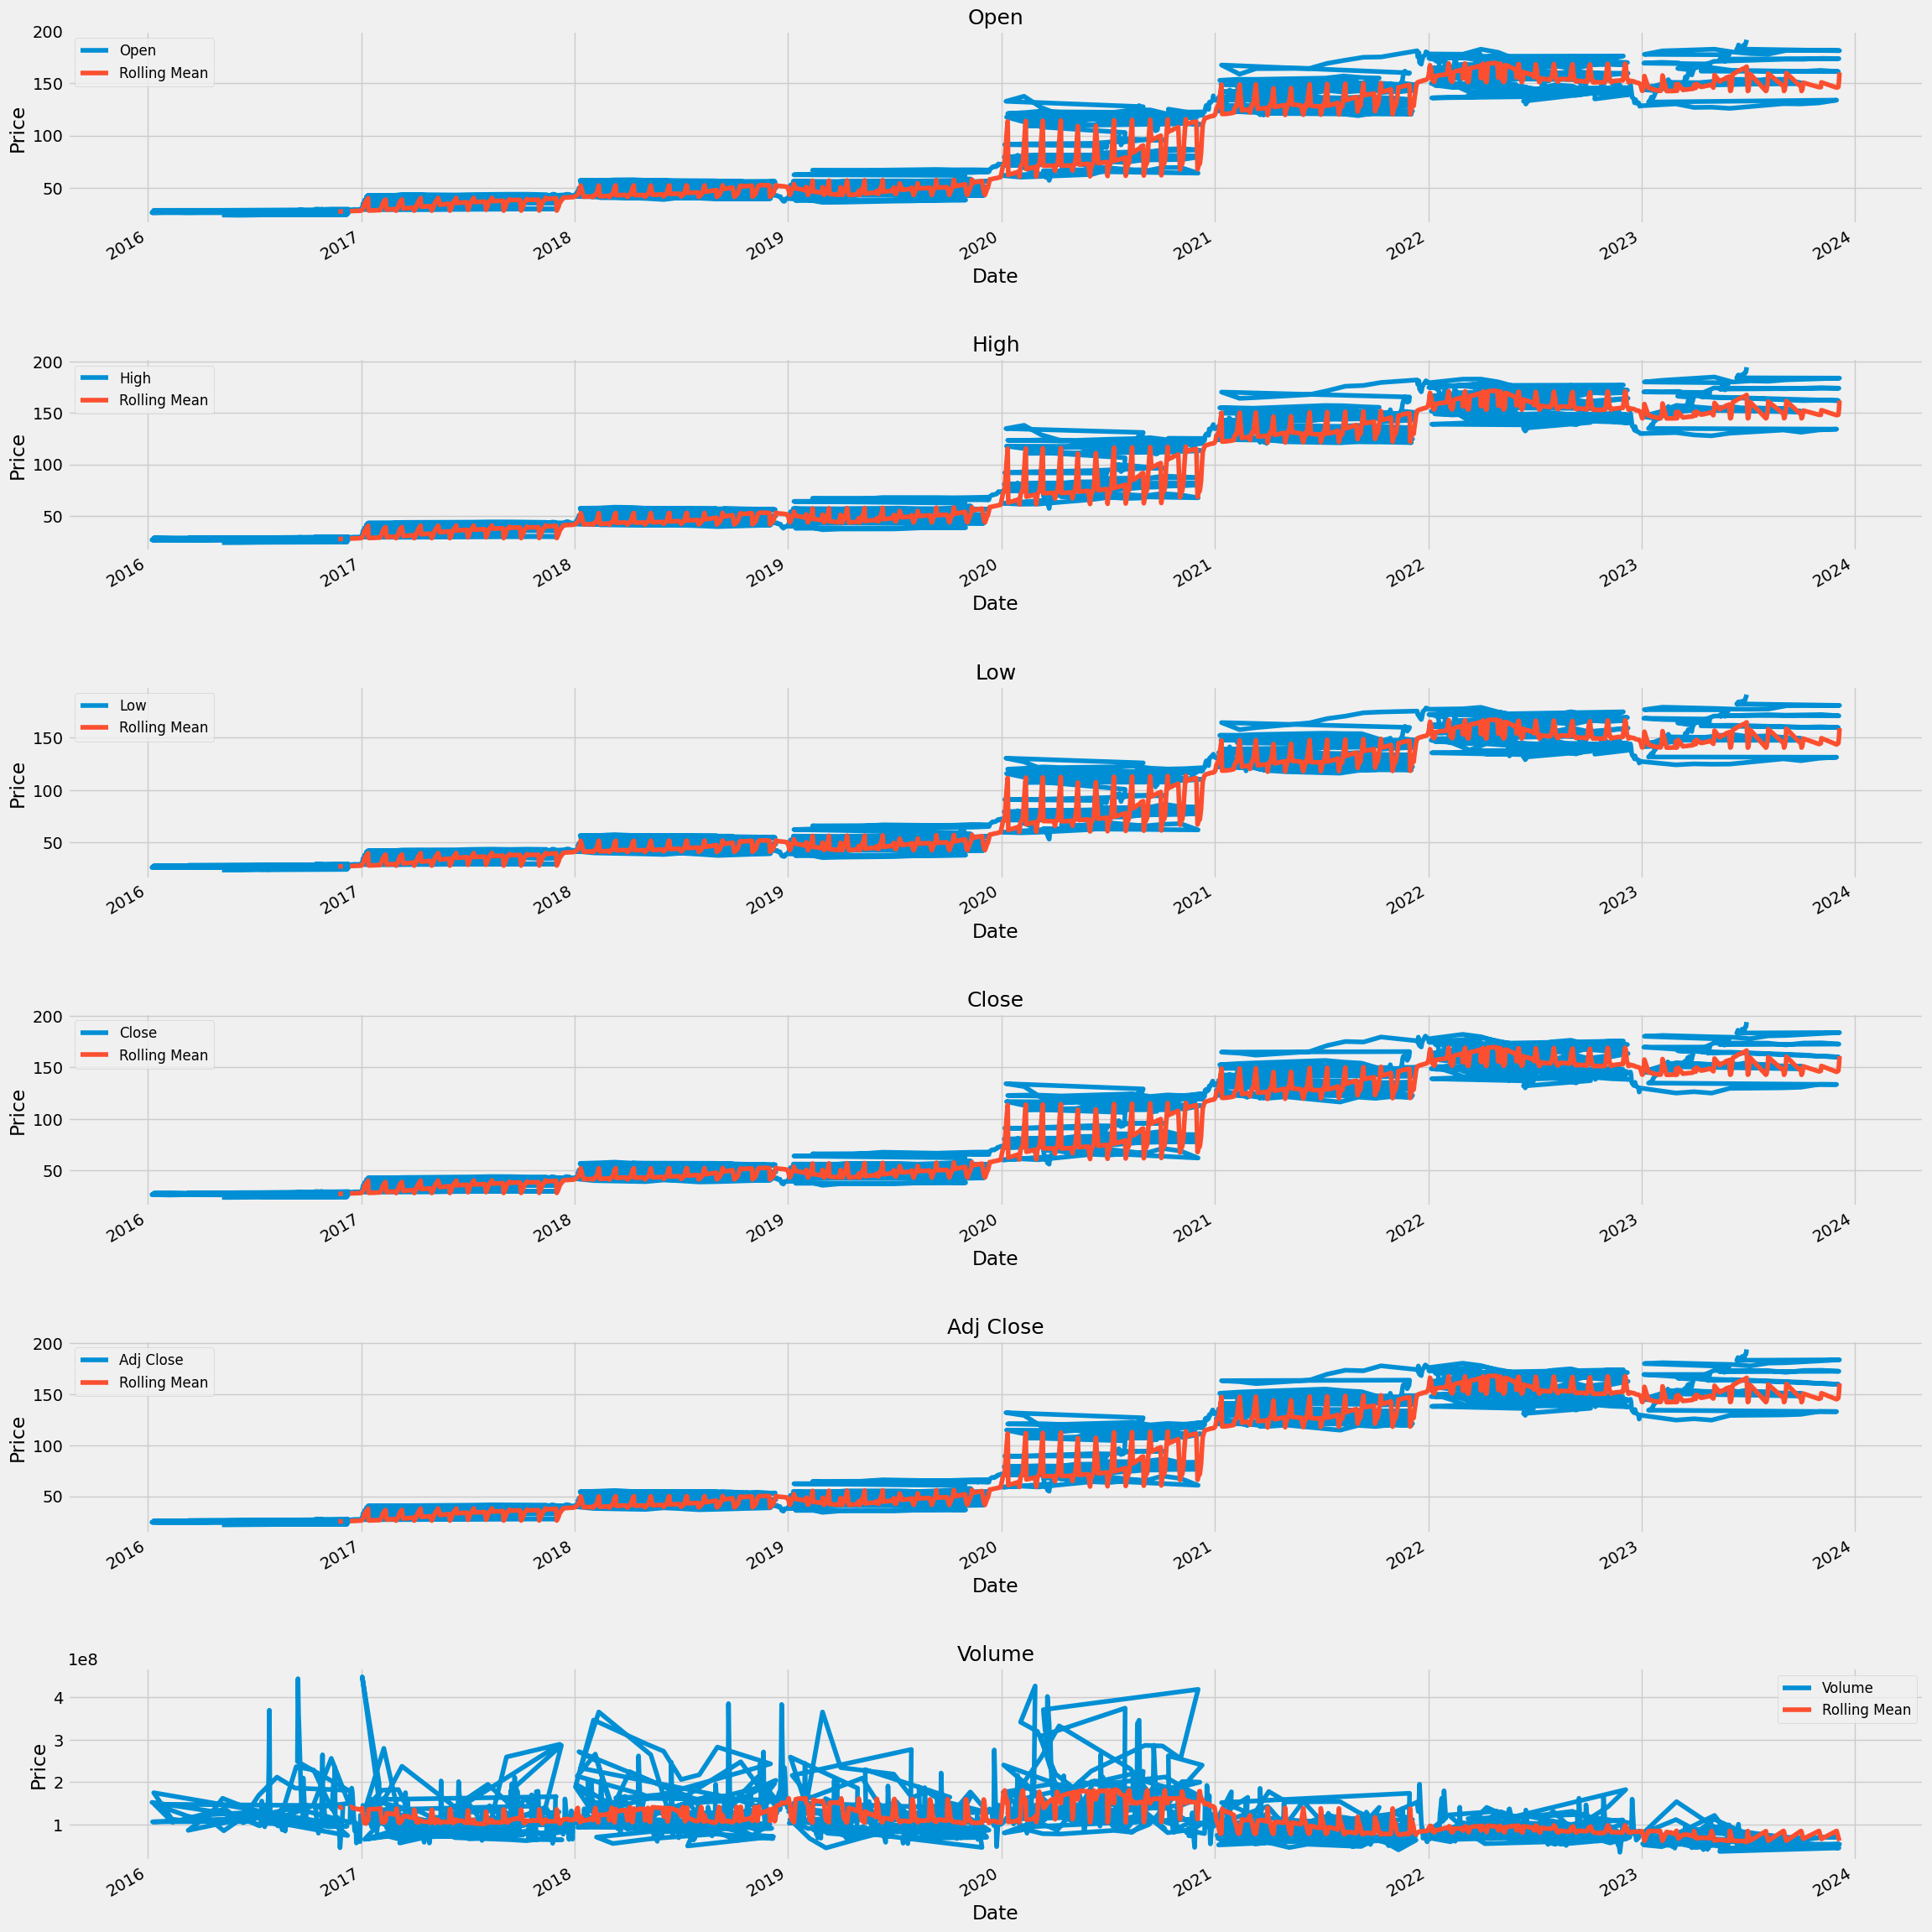

In [141]:
col_names = data.columns

fig = plt.figure(figsize=(24, 24))
for i in range(6):
  ax = fig.add_subplot(6,1,i+1)
  ax.plot(data.iloc[:,i],label=col_names[i])
  data.iloc[:,i].rolling(100).mean().plot(label='Rolling Mean')
  ax.set_title(col_names[i],fontsize=18)
  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  ax.patch.set_edgecolor('black')  
  plt.style.context('fivethirtyeight')
  plt.legend(prop={'size': 12})
  plt.style.use('fivethirtyeight')

fig.tight_layout(pad=3.0)

plt.show()

<AxesSubplot: >

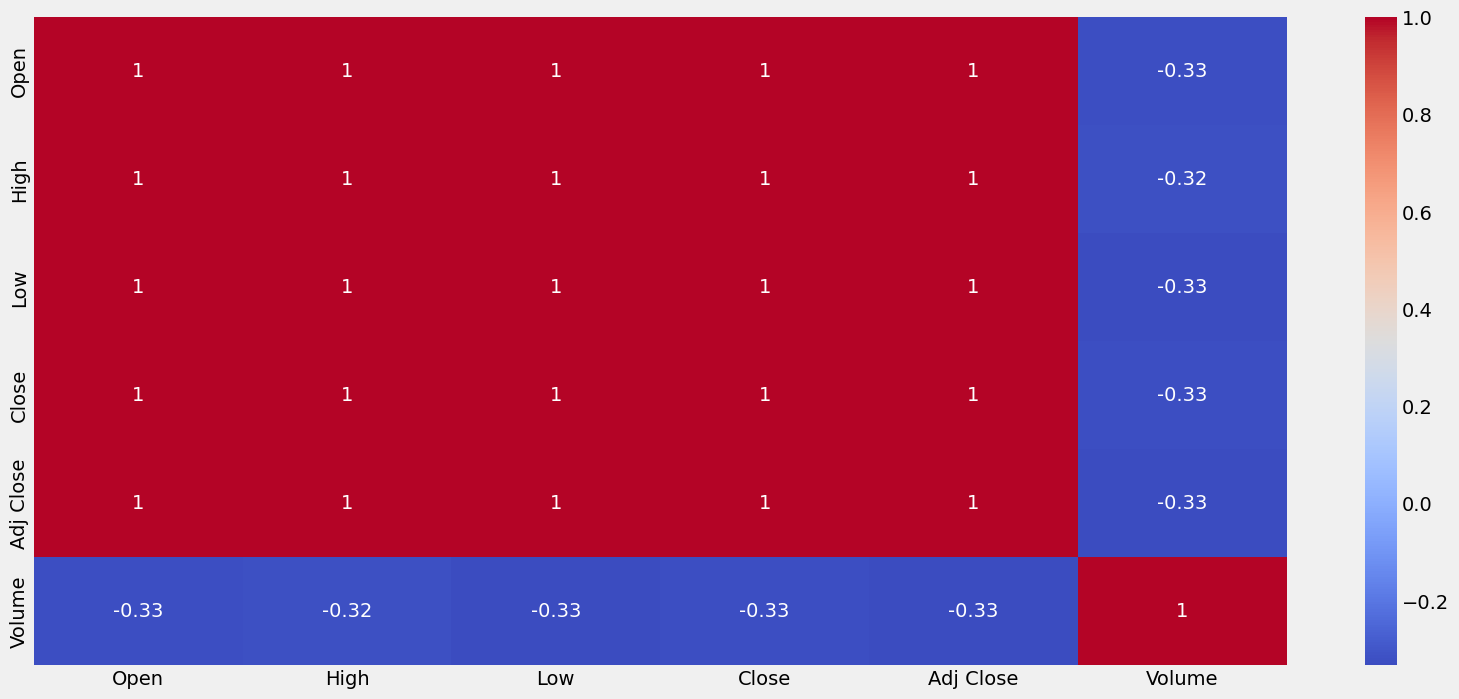

In [142]:
sns.heatmap(data.corr(),annot=True,cmap='coolwarm')

We can eliminate features like Open,Low, High Close automatically as they are high multicollinear with Adj Close .

We consider Adj Close as our target variables as it accounts for all corporate decisions like stock split and dividents.

In [143]:
##Data after feature selection
data_feature_selected = data.drop(axis=1,labels=['Open','High','Low','Close','Volume'])

In [144]:
data_feature_selected

,Adj Close,Date
Date,,
2016-05-07,21.927603,2016-05-07
2016-06-07,22.052250,2016-06-07
2016-07-07,22.146894,2016-07-07
2016-08-07,22.317719,2016-08-07
2016-11-07,22.386971,2016-11-07
...,...,...
2023-06-26,185.270004,2023-06-26
2023-06-27,188.059998,2023-06-27
2023-06-28,189.250000,2023-06-28


In [145]:
col_order = ['Date','Adj Close']
data_feature_selected = data_feature_selected.reindex(columns=col_order) #reindexing
data_feature_selected

,Date,Adj Close
Date,,
2016-05-07,2016-05-07,21.927603
2016-06-07,2016-06-07,22.052250
2016-07-07,2016-07-07,22.146894
2016-08-07,2016-08-07,22.317719
2016-11-07,2016-11-07,22.386971
...,...,...
2023-06-26,2023-06-26,185.270004
2023-06-27,2023-06-27,188.059998
2023-06-28,2023-06-28,189.250000


In [146]:
##Resample Data to Monthly instead of Daily by Aggregating Using Mean
monthly_mean = data_feature_selected['Adj Close'].resample('M').mean()

In [147]:
monthly_data = monthly_mean.to_frame()
monthly_data

,Adj Close
Date,
2016-01-31,25.167481
2016-02-29,25.164610
2016-03-31,25.385708
2016-04-30,25.396147
2016-05-31,24.641076
...,...
2023-08-31,164.492019
2023-09-30,156.615747
2023-10-31,152.914627


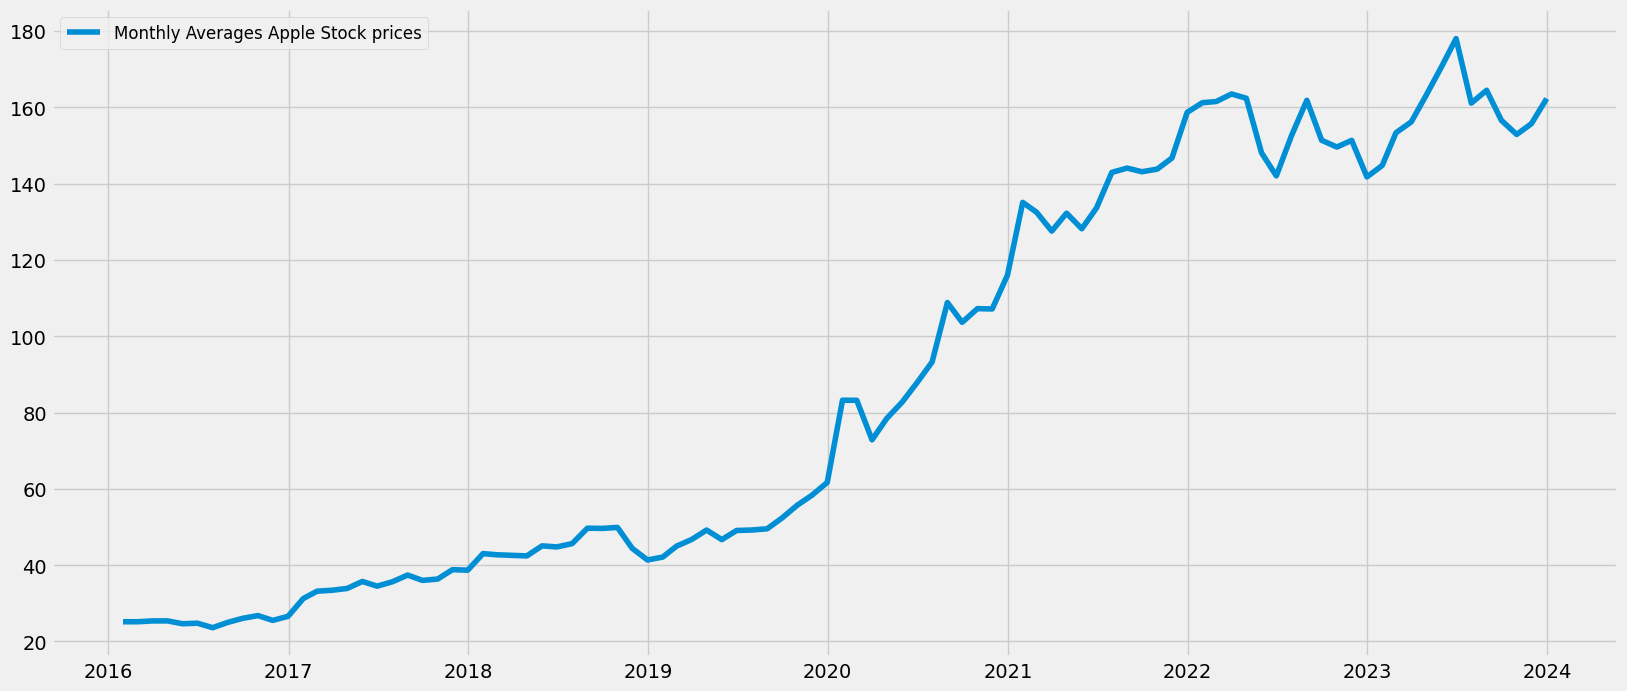

In [148]:
##Monthly Stock Price 
fig = plt.figure(figsize=(18,8))
plt.plot(monthly_data['Adj Close'],label='Monthly Averages Apple Stock prices')
ax.set_title('Monthly Resampled Data')
plt.legend(prop={'size': 12})
plt.show()

## EDA

In [149]:
monthly_data['Year'] = monthly_data.index.year
monthly_data['Month'] = monthly_data.index.strftime('%B')
monthly_data['dayofweek'] = monthly_data.index.strftime('%A')
monthly_data['quarter'] = monthly_data.index.quarter
monthly_data

,Adj Close,Year,Month,dayofweek,quarter
Date,,,,,
2016-01-31,25.167481,2016,January,Sunday,1
2016-02-29,25.164610,2016,February,Monday,1
2016-03-31,25.385708,2016,March,Thursday,1
2016-04-30,25.396147,2016,April,Saturday,2
2016-05-31,24.641076,2016,May,Tuesday,2
...,...,...,...,...,...
2023-08-31,164.492019,2023,August,Thursday,3
2023-09-30,156.615747,2023,September,Saturday,3
2023-10-31,152.914627,2023,October,Tuesday,4


Text(0.5, 1.0, 'Distribution Plot Adj Close -AAPL')

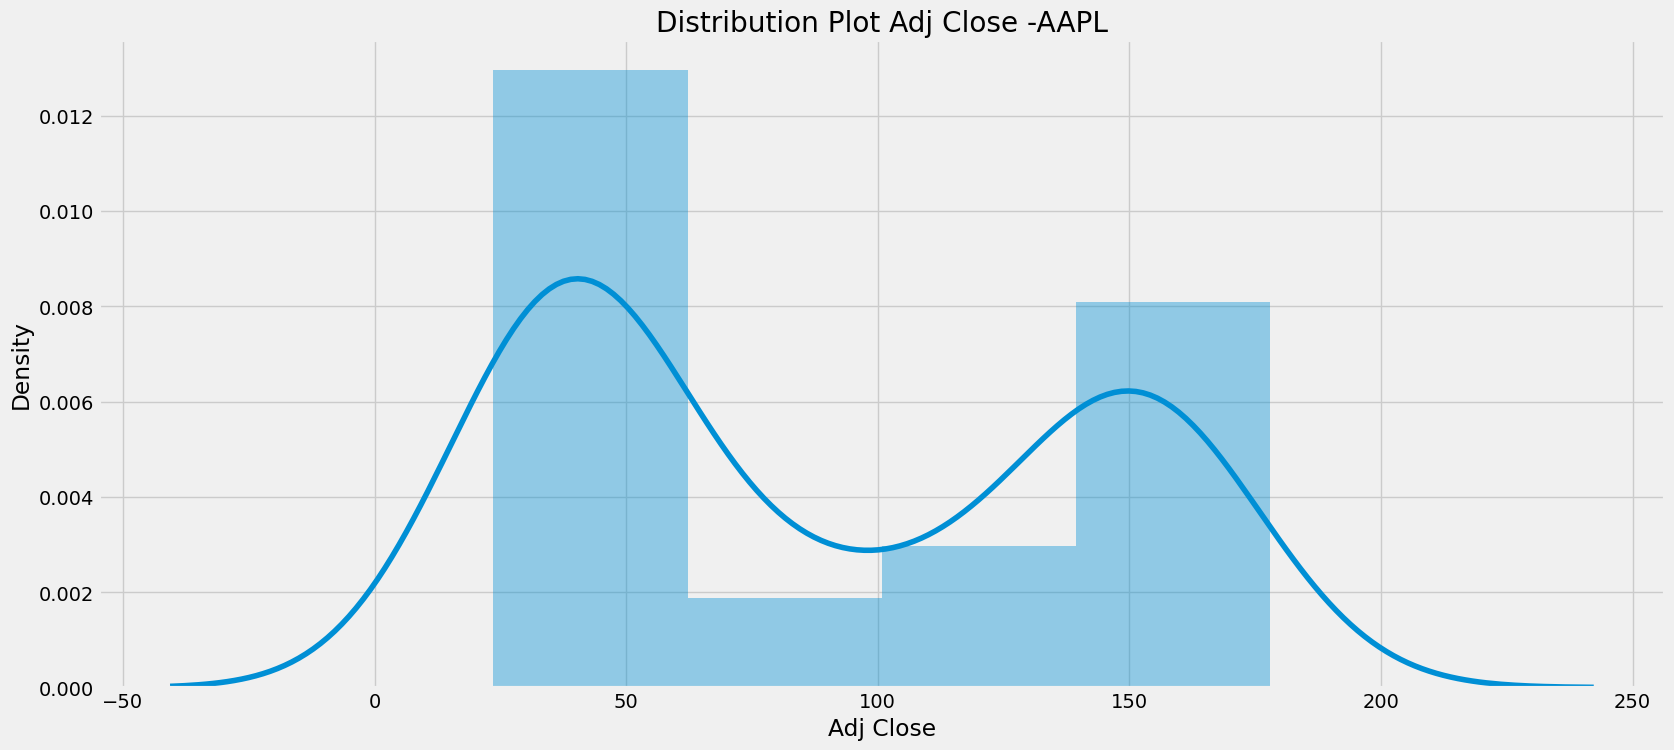

In [150]:
##Checking Distribution of Our Data 
sns.distplot(monthly_data['Adj Close']).set_title("Distribution Plot Adj Close -AAPL")

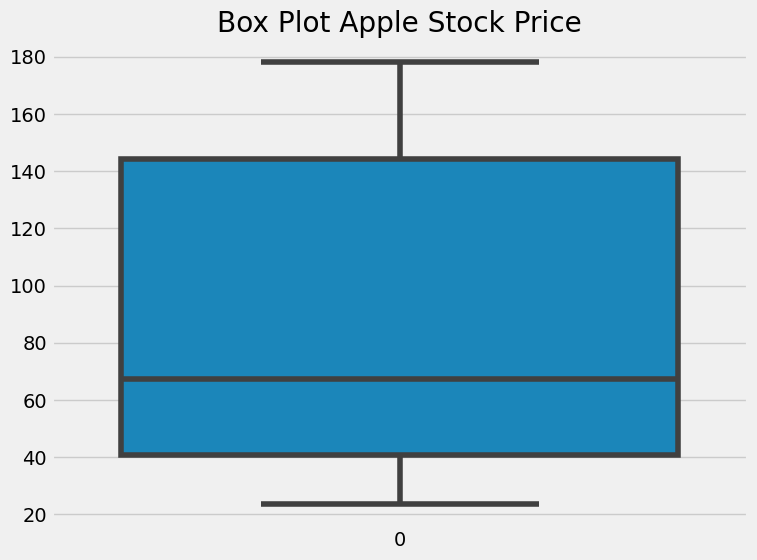

In [151]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(monthly_data['Adj Close']).set_title('Box Plot Apple Stock Price')
plt.style.context('fivethirtyeight')

Right Skewed

Text(0.5, 1.0, 'Qunatile-Quantile Plot Apple Stock Price')

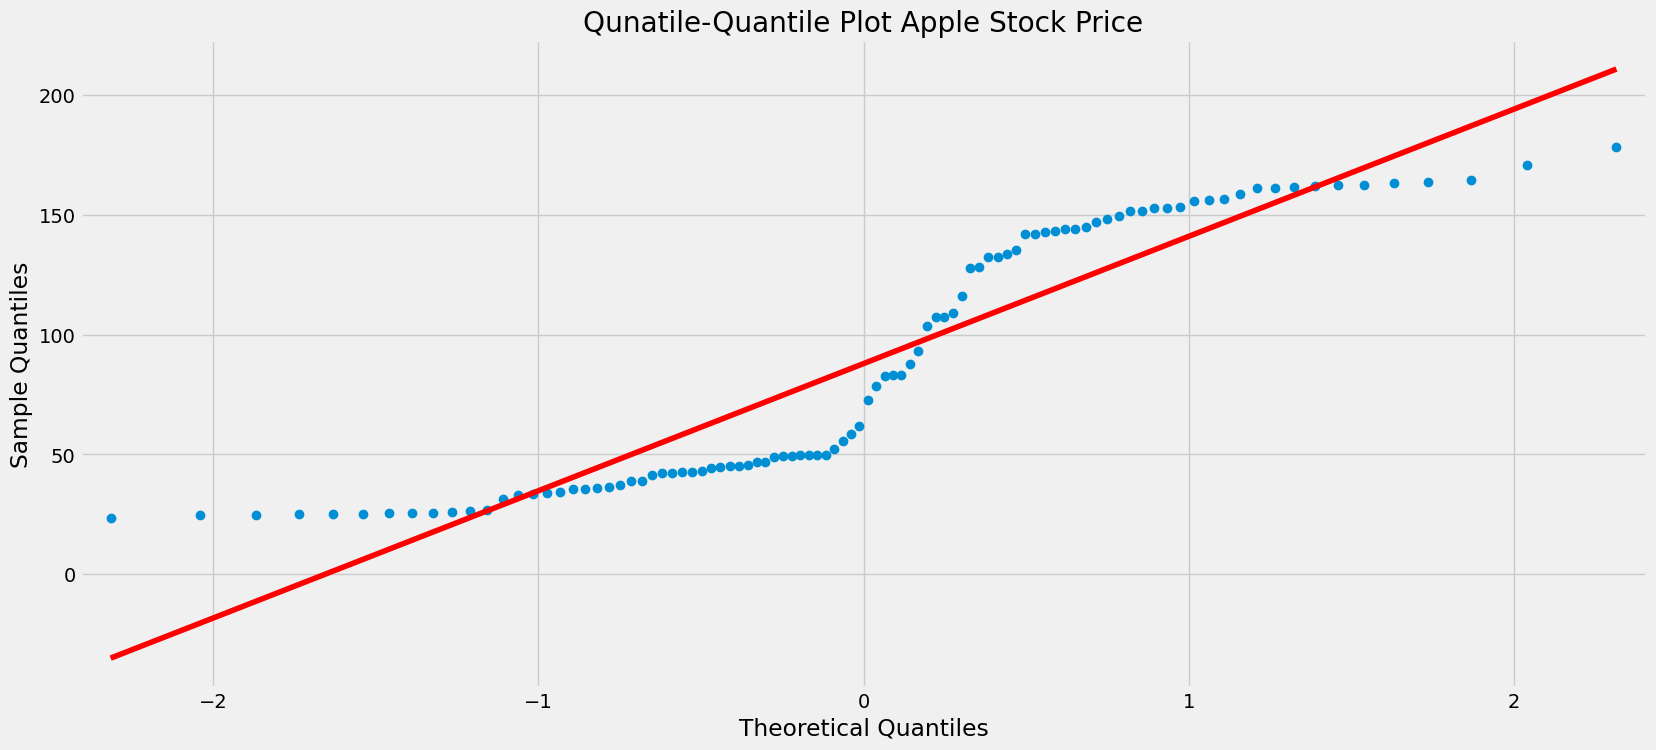

In [152]:
qq_plot = qq(monthly_data['Adj Close'],line='s')
plt.title('Qunatile-Quantile Plot Apple Stock Price')

Not following gausian noraml distribution

In [153]:
print('Skewness of Distribution is ',monthly_data['Adj Close'].skew())

Skewness of Distribution is  0.26744017392898006


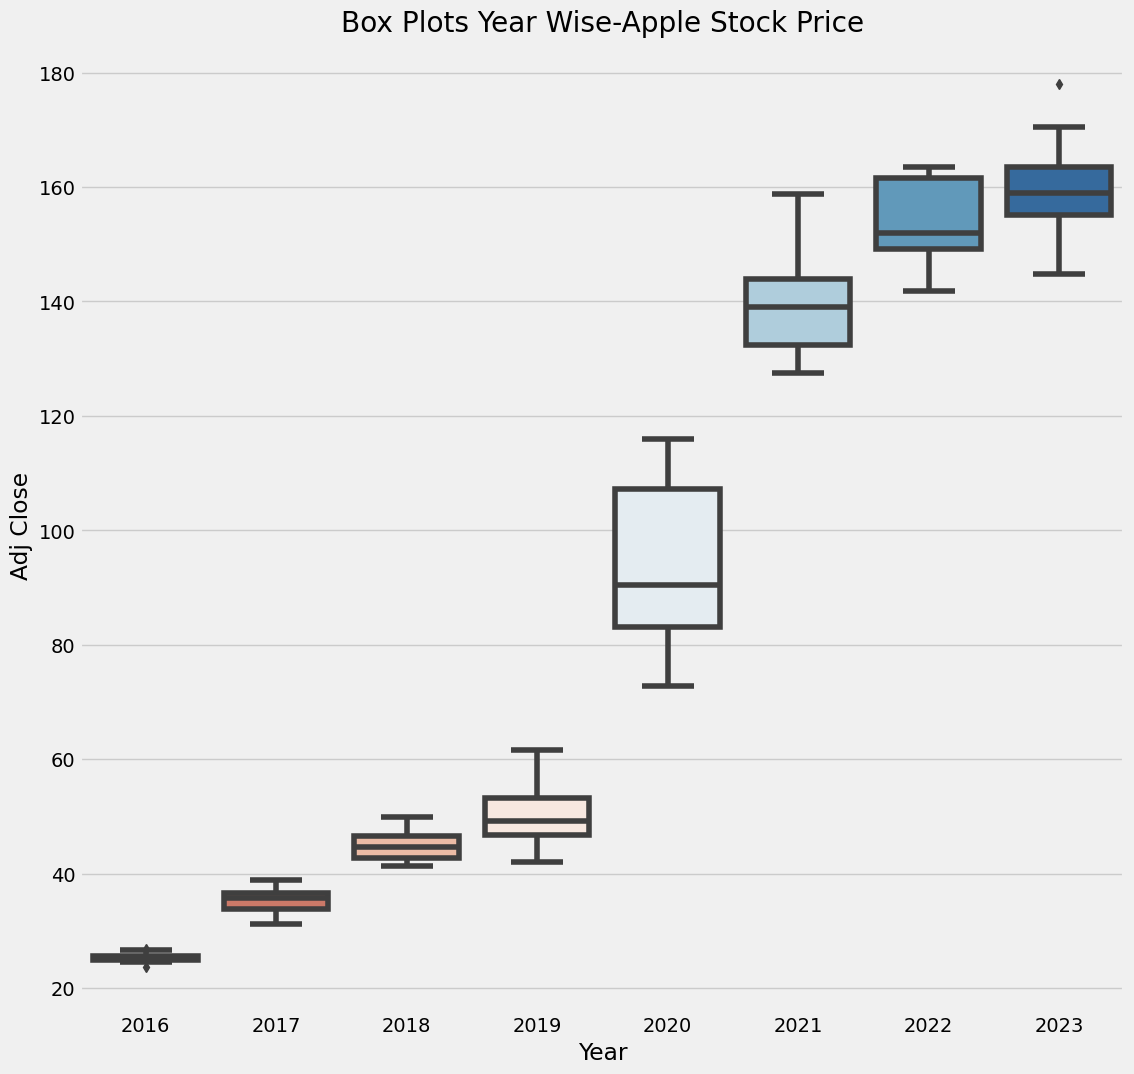

In [154]:
plt.figure(figsize=(12,12))
ax = sns.boxplot(x=monthly_data['Year'],y=monthly_data['Adj Close'],palette='RdBu')
ax.set_title('Box Plots Year Wise-Apple Stock Price')
plt.style.context('fivethirtyeight')

outliers in 2016, 2023

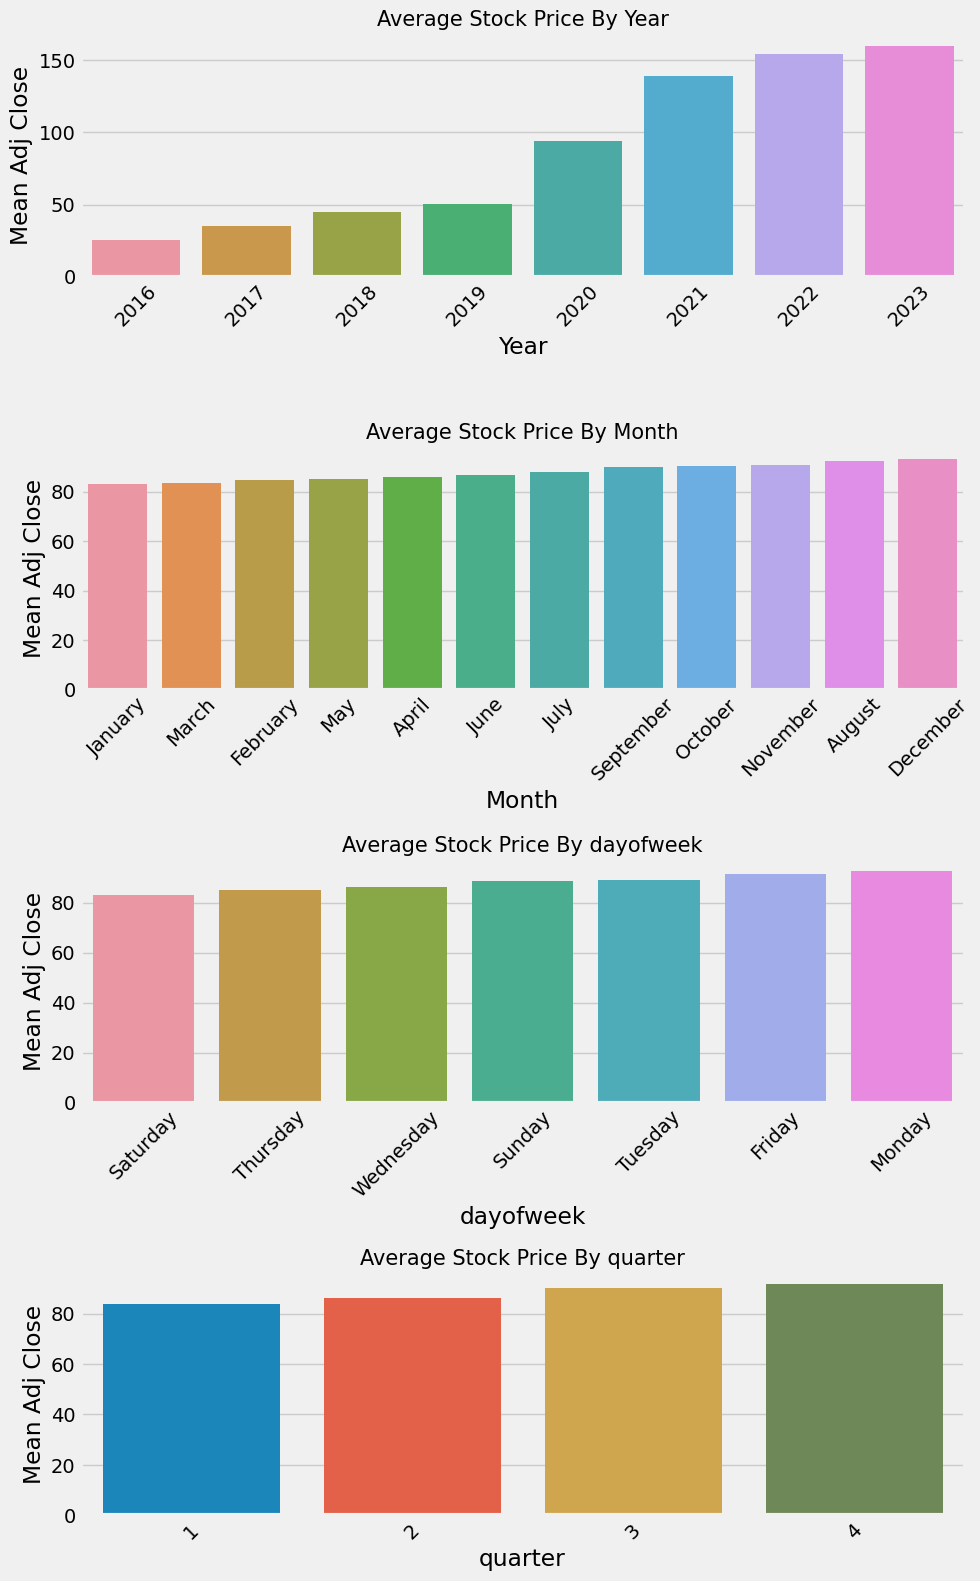

In [155]:
fig = plt.figure(figsize=(10,16))
group_cols = monthly_data.columns

for enum,i in enumerate(group_cols[1:]):
  ax = fig.add_subplot(4,1,enum+1)
  Aggregated = pd.DataFrame(monthly_data.groupby(str(i))["Adj Close"].mean()).reset_index().sort_values('Adj Close')
  sns.barplot(data=Aggregated,x=str(i),y="Adj Close",ax=ax)
  ax.set(xlabel=str(i), ylabel='Mean Adj Close')
  ax.set_title("Average Stock Price By {}".format(str(i)),fontsize=15)
  plt.xticks(rotation=45)
  
plt.tight_layout(pad=1)

Everything is either same or little bit increasing

## Decompostion of time series

<Figure size 2000x1600 with 0 Axes>

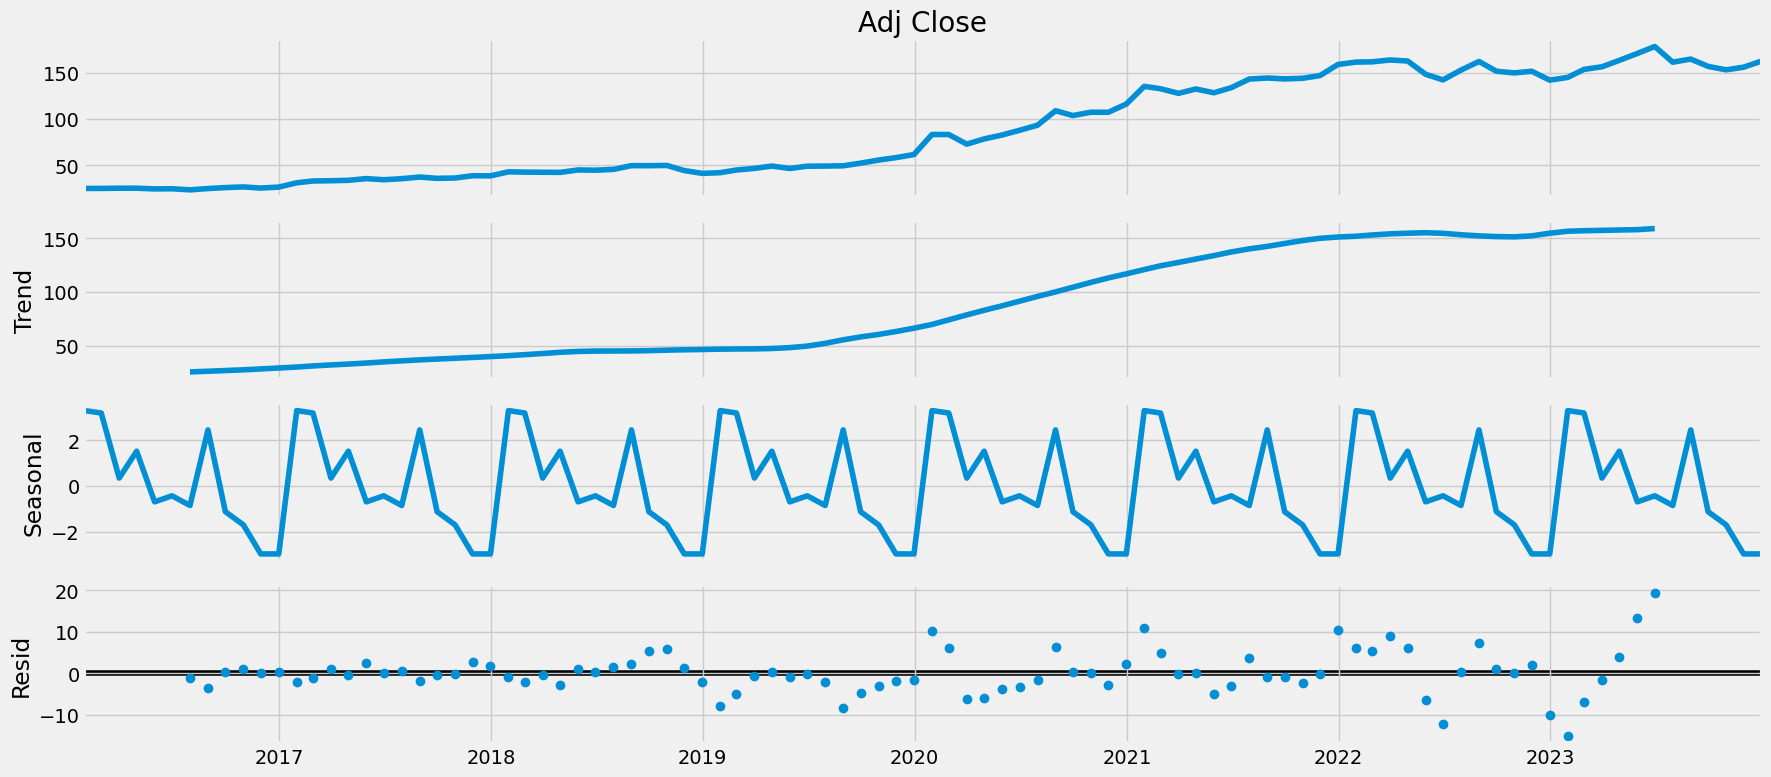

In [156]:
rcParams['figure.figsize'] = 18, 8
plt.figure(figsize=(20,16))
decomposed_series = sd(monthly_data['Adj Close'],model='additive',period=12)
decomposed_series.plot()
plt.show()

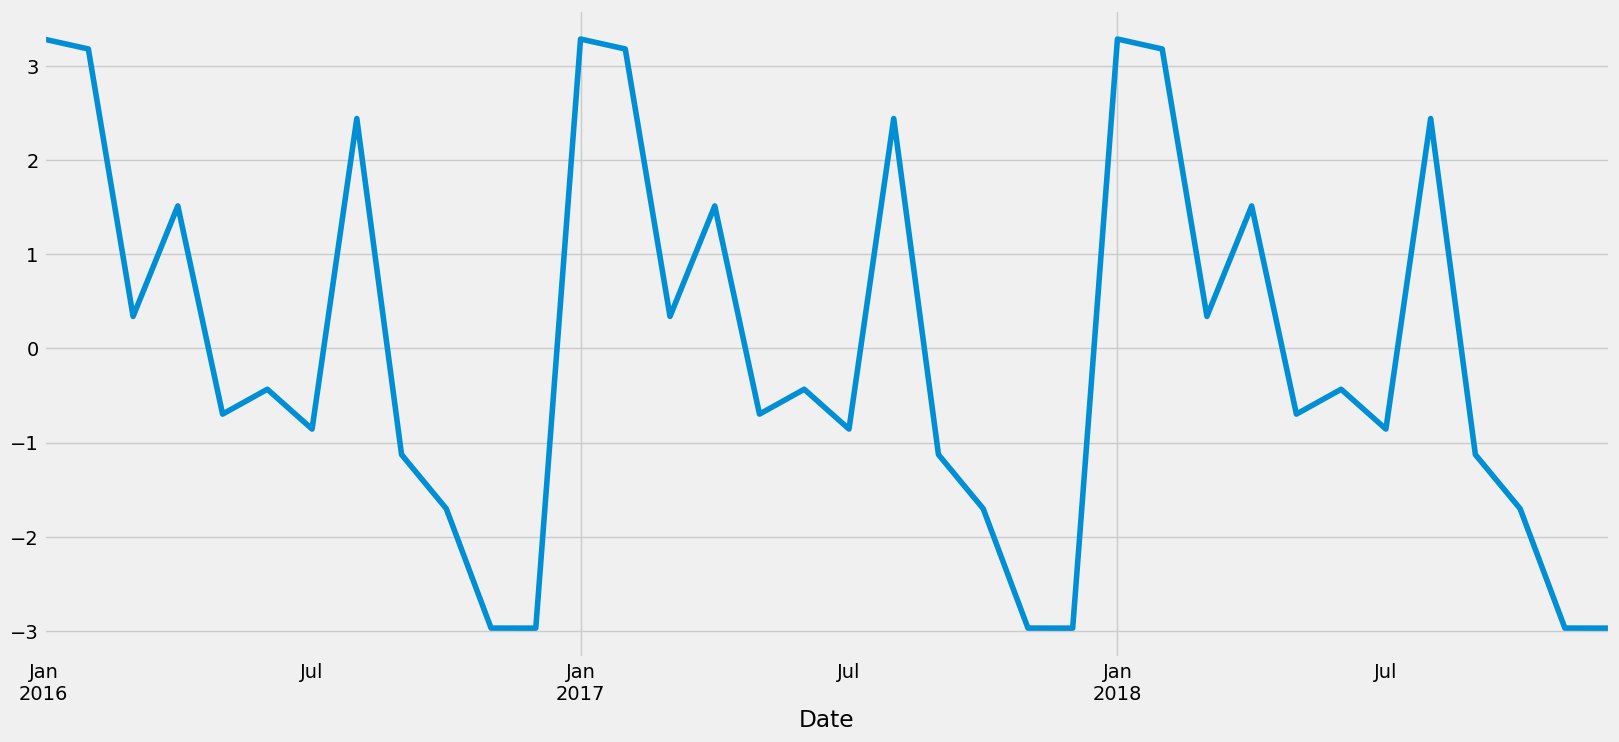

<Figure size 800x800 with 0 Axes>

In [157]:
decomposed_series.seasonal['2016':'2018'].plot()
fig = plt.figure(figsize=(8,8))

--Overall an Upward Trend

--There appears to be seasonality,AAPL has rallied during jan, july

Stationarity Test of Time Series, Using Augmented Dickey-Fuller(ADF) Test

Time Series is Stationary if we have constant mean,constant variance and No Trend and Seasonality.

In [158]:
def ad_fuller_func(X):
  result_ad_fuller = adfuller(X)
  print('ADF Statistic: %f' % result_ad_fuller[0])
  print('p-value: %f' %result_ad_fuller[1])
  print('Critical Values:')
  for key, value in result_ad_fuller[4].items():
      print('\t%s: %.3f' % (key, value))
 
  if result_ad_fuller[0] < result_ad_fuller[4]['5%']:
    print('Reject Null Hypothesis-Time Series is Stationary')
  else:
    print('Failed to Reject Hypothesis-Time Series is Non-Stationary')
    
# reference: Stackoverflow

In [159]:
ad_fuller_func(monthly_data['Adj Close'])

ADF Statistic: -0.245500
p-value: 0.932876
Critical Values:
	1%: -3.501
	5%: -2.892
	10%: -2.583
Failed to Reject Hypothesis-Time Series is Non-Stationary


Time Series is Not Stationary as observed earlier also by Decomposition(Trend and Seasonality Present)

Statistically verified by ADF Test

Text(0.5, 0, 'Lags')

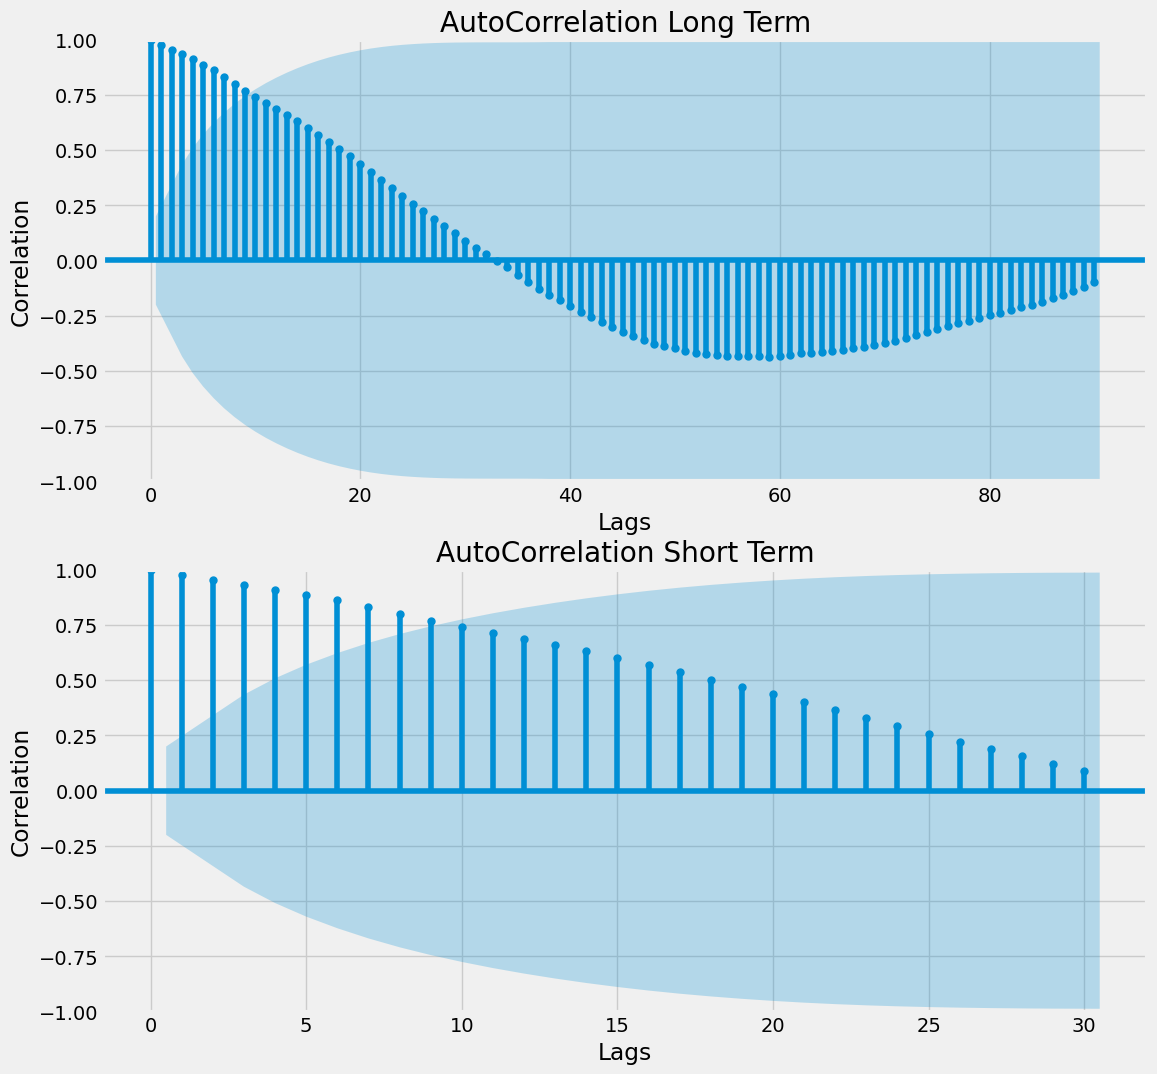

In [160]:
# Auto correlation function
fig,(ax1,ax2) = plt.subplots(2,figsize=(12,12))
acf = plot_acf(monthly_data['Adj Close'],lags=90,ax=ax1)
ax1.set_title('AutoCorrelation Long Term')
acf = plot_acf(monthly_data['Adj Close'],lags=30,ax=ax2)
ax2.set_title('AutoCorrelation Short Term')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')

Slow Decay of correlation values indicates that the future values are heavily dependent on the lagged values . This shows that the series is not random and good for time series modelling .

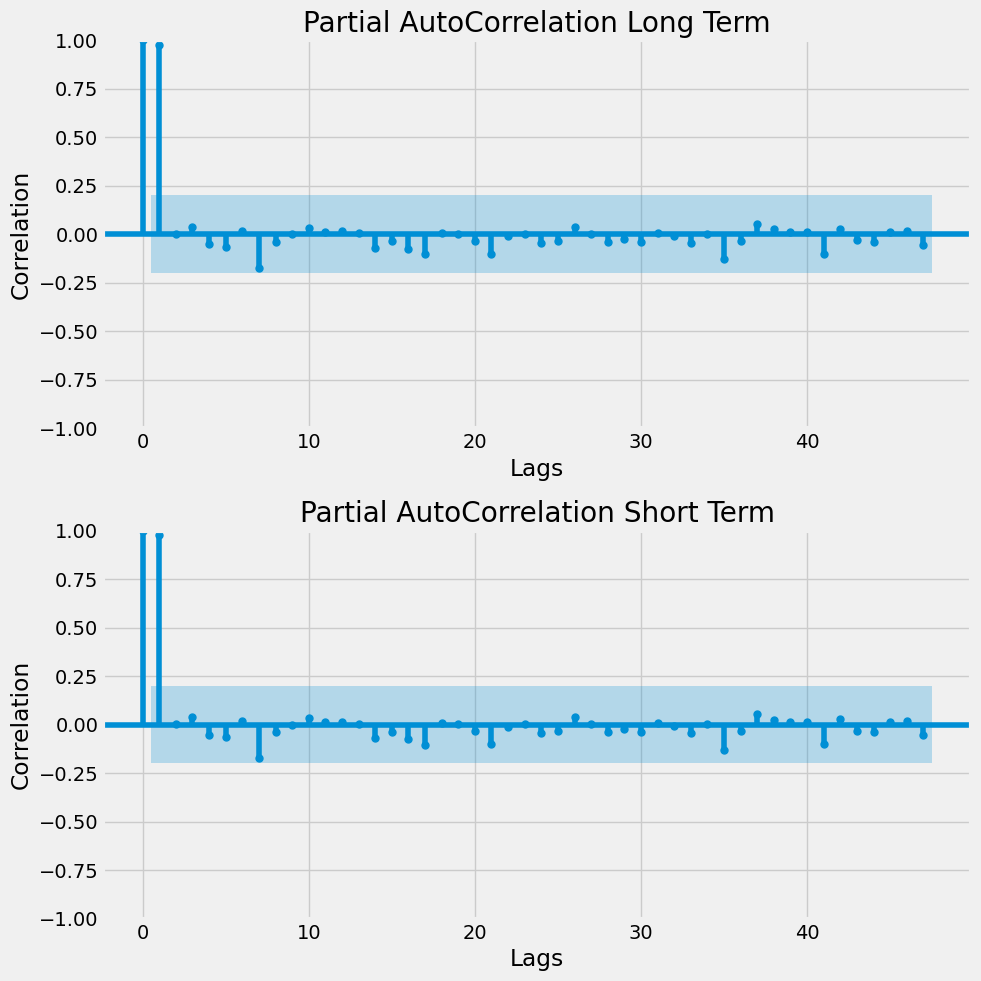

In [161]:
# PACF
fig,(ax1,ax2) = plt.subplots(2,figsize=(10,10))
pacf = plot_pacf(monthly_data['Adj Close'],lags=47,ax=ax1)
ax1.set_title('Partial AutoCorrelation Long Term')
pacf = plot_pacf(monthly_data['Adj Close'],lags=47,ax=ax2)
ax2.set_title('Partial AutoCorrelation Short Term')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')
plt.tight_layout(pad=1)

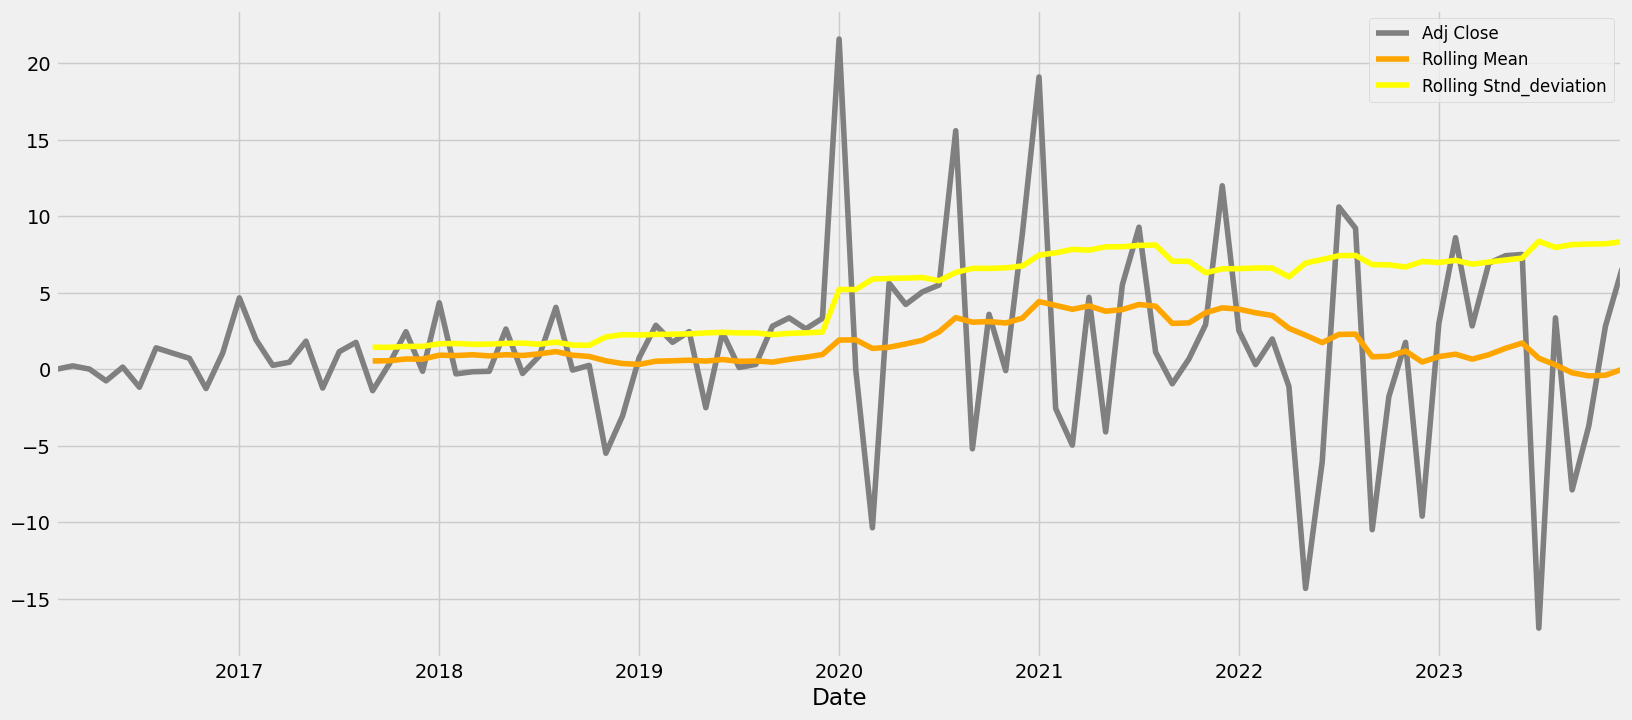

In [162]:
# Transformations To Make Series Stationary
monthly_diff = monthly_data['Adj Close'] - monthly_data['Adj Close'].shift(1)
monthly_diff[1:].plot(c='grey')
monthly_diff[1:].rolling(20).mean().plot(label='Rolling Mean',c='orange')
monthly_diff[1:].rolling(20).std().plot(label='Rolling Stnd_deviation',c='yellow')
plt.legend(prop={'size': 12})